In [ ]:
!nvidia-smi

Tue Sep  1 00:14:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


DATA-1. objectify
============

In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random

from datetime import timedelta, datetime
import dateutil

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_validation = path + 'validation'
path_test = path + 'testing'
path_submission = path

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
stride = 10
epoch = 25
batch_size = 32
timelen = 100

In [ ]:
def check_timestamp_continuous(df):
    temp = df.iloc[:,0]
    for i in range(len(temp)-1):
        if dateutil.parser.parse(temp.iloc[i+1]) - dateutil.parser.parse(temp.iloc[i]) != timedelta(seconds=1):  #parse 는 자동으로 datetime object 를 생성. datetime - datetime 은 timedelta object 생성.
            return False
    return True

def read_data(path):
    file_paths = glob.glob(path+'/*.csv')
    df = pd.DataFrame()
    for file in file_paths:
        f=pd.read_csv(file)
        print('time continuity : ',check_timestamp_continuous(f))
        df = df.append(f, ignore_index=True)
    columns = list(df.columns)
    columns.remove('time')
    return df, columns

def boundary_check(df):
    x = np.array(df.drop('time',axis=1), dtype=np.float32)
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')

def normalization(df,columns):
    for column in columns:
        maxi = df[column].max()
        mini = df[column].min()
        if maxi == mini:
            df[column] = df[column].apply(lambda x : 0)
        else:
            df[column] = df[column].apply(lambda x : (x - mini)/(maxi - mini))
    boundary_check(df)        
    return df

train, columns= read_data(path_train)
train = normalization(train, columns)
train

time continuity :  True
time continuity :  True
time continuity :  True
Boundary Clear


,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,0.378953,0,0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,0.481272,0.260132,0.200820,0,0.478068,0.357101,0.881536,0,0,0.270592,0,0,0.045701,0.708779,0,0.406877,0.289495,0.0,0.317237,0.139665,0.983325,0.331731,0,0,0,1.0,0,0.482697,0.661946,0,1.0,0.215404,0,0.642237,0.373146,0.444904,0.465909,0.0,0.392405,0.047904,0,0,0.574348,1.0,0.206193,0.996286,0.049420,0.000870,0,0.996286,0,0.480318,0,0,0,0.189004,0,0.989609,0.808081,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,2020-07-11 00:00:01,0.378459,0,0,0.226548,0.351630,0.000154,0.400309,0.359799,0.795139,0.543787,0.517171,0.246802,0.200820,0,0.476524,0.357101,0.888848,0,0,0.264089,0,0,0.042571,0.709256,0,0.406877,0.289765,0.0,0.316404,0.139665,0.984469,0.331731,0,0,0,1.0,0,0.482697,0.661431,0,1.0,0.232863,0,0.551026,0.377049,0.574404,0.522727,0.0,0.405063,0.043627,0,0,0.576815,1.0,0.207052,0.993659,0.048721,0.000609,0,0.993659,0,0.451108,0,0,0,0.188535,0,0.989609,0.808081,0.592759,0.0,0.326835,0.254278,0.337838,0.916661,0.266530,0.250469,1.00000,0.506623
2,2020-07-11 00:00:02,0.378459,0,0,0.226810,0.314829,0.000154,0.392647,0.461334,0.804977,0.538611,0.496060,0.252053,0.200922,0,0.479610,0.357101,0.911883,0,0,0.262481,0,0,0.039023,0.709324,0,0.404259,0.289765,0.0,0.315852,0.139665,0.982944,0.326923,0,0,0,1.0,0,0.482697,0.661090,0,1.0,0.251605,0,0.449923,0.377439,0.693722,0.655303,0.0,0.392405,0.040205,0,0,0.577754,1.0,0.206049,0.991429,0.048721,0.000609,0,0.991429,0,0.456287,0,0,0,0.187396,0,0.989609,0.878788,0.595906,0.0,0.326338,0.255413,0.337838,0.916661,0.265099,0.255028,1.00000,0.464946
3,2020-07-11 00:00:03,0.378953,0,0,0.226810,0.229915,0.000154,0.393743,0.309032,0.814815,0.450733,0.479229,0.247947,0.200820,0,0.479610,0.357101,0.923035,0,0,0.265487,0,0,0.035476,0.709596,0,0.408186,0.289495,0.0,0.307291,0.139665,0.988280,0.331731,0,0,0,1.0,0,0.482697,0.655771,0,1.0,0.260847,0,0.324038,0.380952,0.827156,0.560606,0.0,0.392405,0.037639,0,0,0.574348,1.0,0.206205,0.992024,0.048721,0.000348,0,0.992024,0,0.508270,0,0,0,0.186994,0,0.989609,0.848485,0.596221,0.0,0.326338,0.257590,0.331076,0.916661,0.264281,0.252816,1.00000,0.443695
4,2020-07-11 00:00:04,0.380435,0,0,0.226810,0.157685,0.000154,0.414918,0.690968,0.824074,0.319543,0.511626,0.245254,0.200922,0,0.476524,0.357101,0.935101,0,0,0.260803,0,0,0.032555,0.709256,0,0.405568,0.289765,0.0,0.308395,0.139665,0.989805,0.331731,0,0,0,1.0,0,0.482697,0.656459,0,1.0,0.281900,0,0.281736,0.382514,0.781466,0.541667,0.0,0.417722,0.035073,0,0,0.576815,1.0,0.207645,0.991231,0.049071,0.000348,0,0.991231,0,0.456890,0,0,0,0.186488,0,0.989609,0.919192,0.599053,0.0,0.326835,0.256196,0.337838,0.916661,0.262577,0.247117,1.00000,0.480956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921598,2020-08-10 10:59:56,0.302372,0,0,0.703684,0.510313,0.000538,0.415518,0.335006,0.064236,0.649781,0.522814,0.477447,0.362090,0,0.857438,0.215741,0.000914,0,0,0.310726,0,0,0.747913,0.777293,0,0.836387,0.520929,0.0,0.379924,0.067039,0.976084,0.271635,0,0,0,1.0,0,0.946227,0.328480,0,1.0,0.001027,0,0.833236,0.482045,0.541112,0.643939,0.0,0.417722,0.749358,0,0,0.585389,1.0,0.734992,0.990289,0.048368,0.752720,0,0.988852,0,0.516113,0,0,0,0.362109,0,0.995982,0.565657,0.683702,0.0,0.300850,0.498045,0.202706,0.111119,0.314110,0.247184,0.26162,0.749435
921599,2020-08-10 10:59:57,0.304842,0,0,0.703684,0.482660,0.0

In [ ]:
class HAI_Dataset():
    def __init__(self, df, timelen=100, stride=10):
        self.data = df.iloc[:, 1:].values
        self.timestamp = df.iloc[:, 0].values
        self.timelen = timelen

        valid_idxs = []
        for i in range(0, len(df) - timelen, stride):
            if dateutil.parser.parse(df.iloc[i + timelen - 1, 0]) - dateutil.parser.parse(df.iloc[i, 0]) == timedelta(
                    seconds=timelen - 1):  # parse 는 자동으로 datetime object 를 생성. datetime - datetime 은 timedelta object 생성.
                valid_idxs.append(i)
        self.valid_idxs = np.array(valid_idxs)
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        X = self.data[i: i + self.timelen - 1]
        Y = self.data[i + self.timelen - 1]
        return X, Y

    def __len__(self):
        return len(self.valid_idxs)


class Dataset_Batch_Loader(keras.utils.Sequence):
    def __init__(self, Dataset, batch_size):
        self.dataset = Dataset
        self.batch_size = batch_size
        self.length = len(Dataset) // batch_size
        idxs = np.arange(len(Dataset))
        random.shuffle(idxs)
        self.randomized_idxs = np.array(idxs)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        index_window = [j for j in range(i, i + self.batch_size)]
        X = np.asarray([self.dataset[k][0] for k in index_window])
        Y = np.asarray([self.dataset[k][1] for k in index_window])
        return X, Y

    def __len__(self):
        return self.length

In [ ]:
Dataset = HAI_Dataset(train, timelen, stride)
DataLoader = Dataset_Batch_Loader(Dataset, batch_size)

# of valid windows: 92131


In [ ]:
def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 14]
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    plt.show()

def generate_and_train_model(Dataset, epoch, batch_size, Modelname):  # loss 에서 대회 주어진거 사용해야할듯
    with tf.device('/device:GPU:0'):
        model = keras.Sequential()
        model.add(layers.Bidirectional(layers.GRU(100,return_sequences=True), merge_mode = 'ave', input_shape = (timelen-1,79)))
        model.add(layers.Bidirectional(layers.GRU(100,return_sequences=True)))
        model.add(layers.Bidirectional(layers.GRU(200)))
        model.add(layers.Dense(79, activation = 'relu'))
        model.compile(optimizer='adam',loss='MSE', metrics=['accuracy'])
        print(model.summary())
        history = model.fit(DataLoader, batch_size = 1, epochs=epoch, verbose=1)
    model.save(path + Modelname + '.h5')
    return model, history


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 99, 100)           108600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 99, 200)           121200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               482400    
_________________________________________________________________
dense (Dense)                (None, 79)                31679     
Total params: 743,879
Trainable params: 743,879
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
2879/2879 [==============================] - 89s 31ms/step - loss: 0.0083 - accuracy: 0.1959
Epoch 2/25
2879/2879 [==============================] - 89s 31ms/step - loss: 0.0042 - accuracy: 0.2386
Epoch 3/25
2879/2879 [=============

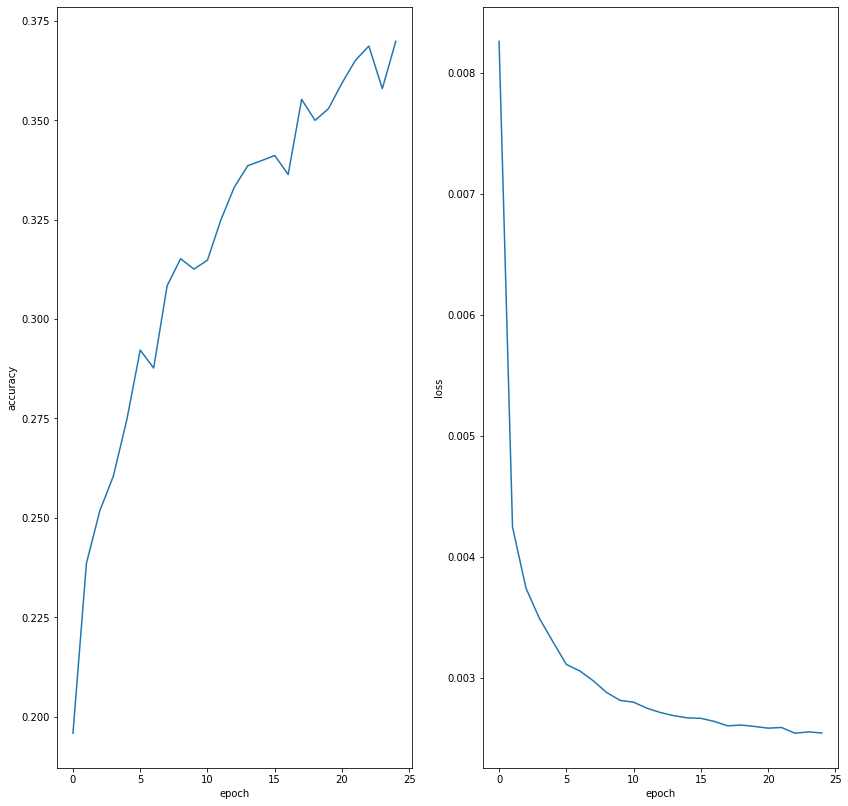

In [ ]:
model, history = generate_and_train_model(Dataset, epoch, batch_size, 'testingmodel')
plot_history(history)

In [ ]:
valid